<a href="https://colab.research.google.com/github/m-mehabadi/grad-maker/blob/main/_notebooks/UniversalAttackGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Areas:
* Domain Generalization in Classification
* Domain Generalization in Mitosis Detection
* Universal Adversarial Example Generator
* An Aproach to Optimize Robustness and Performance Simultaneously
* Multi-Tasking using GradMaker
* Applications in Federated Learning


In [ ]:
!pip install tqdm

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import gc
import torch.nn.functional as F
from torch.autograd import Variable

from tqdm.auto import tqdm

In [ ]:
# config
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Param
num_epochs = 10
num_classes = 10
batch_size = 200
learning_rate = 0.001

In [ ]:
# MNIST datasets
train_dataset = torchvision.datasets.MNIST(root='./', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./', train=False, transform=transforms.ToTensor(), download=True)

# MNIST dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
# CNN(two layer)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
def validate(model, dloader, pert=None, is_batched=True):
    model.eval()
    correct = 0
    total = 0
    pert_ = pert(model, dloader) if (not is_batched) and (pert is not None) else None
    for i, (images, labels) in enumerate(tqdm(dloader)):
        images = images.to(device)
        labels = labels.to(device)
        
        #
        if pert is not None:
            images = Variable(images.clone(), requires_grad=True)
            pert_ = pert(model, images, labels) if is_batched else pert_
            images = images.data.detach() + pert_.data.detach()
        #
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #
        # print(f"Batch {i}/{len(dloader)}, processed.")

        gc_collect(pert_, images, labels, outputs, predicted, _)
        empty_cache()
    return (100 * correct / total)

In [ ]:
def gc_collect(*vars):
    for var in vars:
        del var
    gc.collect()

def empty_cache():
    torch.cuda.empty_cache()

In [ ]:
model = ConvNet(num_classes).to(device)

# Loss and optimize
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train
model.train()
total_step = len(train_loader)
for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if (i + 1) % 100 == 0:
        #     print (f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Training Loss: {loss.item():.4f}')

# Test the model
print(f'Model Accuracy on the 10000 test images: {validate(model, test_loader):.4f} %')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Model Accuracy on the 10000 test images: 99.0800 %


### Now let's generate the attack


In [ ]:
def adv_clip(adv, real, alpha=0):
    return torch.clamp(adv, min=torch.clamp(real-alpha, min=0.),
                       max=torch.clamp(real+alpha, max=1.))

In [ ]:
def accuracy(model, X, y):
    outputs = model(X)
    _, predicted = torch.max(outputs.data, 1)
    total = y.size(0)
    correct = (predicted == y).sum().item()
    return correct / total

In [ ]:
def gradient_maker(domain_grads, epsilon=0.5, alpha=0.01, eff=0.1):
    ###### NOTES:
    ### make sure that `domain_grads` dtype is float precision not integer or long.

    def log():
        # print(f"g={g}")
        print(f"Iter={iter}, Condition={np.min(dgr@g/dim)}")

    def null(A):
        from scipy.linalg import null_space
        n = null_space(A, rcond=1)
        if n.shape[1] < 1:
            return False, None
        r = np.sqrt(np.sum((A@n)**2, axis=0)/n.shape[1])
        if np.min(r) >= 1e-2:
            return False, None
        return True, n.T[np.argmin(r)].reshape(-1, 1)
    
    def scale():
        G = np.concatenate((g.reshape(1, -1), domain_grads), axis=0)
        is_fine, n = null(G@G.T)
        if not is_fine:
            return np.mean(np.sqrt(np.sum(domain_grads**2, axis=1)))/np.sqrt(np.sum(g**2))
        # print(n)
        n /= np.sum(n[1:])
        # print(n)
        return np.abs(n[0,0])

    dgr = np.copy(domain_grads)
    number_of_domains, dim = dgr.shape

    #
    dgr /= np.sqrt(np.sum(dgr**2, axis=1))[:, np.newaxis]
    
    #
    g = np.random.randn(dim)
    g /= np.sqrt(np.sum(g**2))
    u_ = np.zeros(number_of_domains)
    
    iter = 0
    while not np.min(dgr@g/dim) >= epsilon:

        log()
        
        u_ = u_ + alpha*((1.+eff)*epsilon - (dgr@g)/dim)
        g = (1./number_of_domains)*np.sum(((1+u_).reshape(number_of_domains, 1))*dgr, axis=0)

        iter += 1
    
    log()
    return scale()*g

In [ ]:
def dX(model, X, y):
    X = Variable(X.data, requires_grad=True)
    outputs = model(X)
    loss = F.cross_entropy(outputs, y)
    loss.backward()
    return X.grad.data.clone()

# def universal_v1(model, X, y, alpha=0.05, steps=2, eps=0.15):
#     X_first = X.clone()
#     for step in range(steps):
#         X_grad = dX(model, X, y)
#         X_advs = adv_clip(X + alpha * torch.sign(gradient_maker(X_grad)), X, eps)
#         X = Variable(X_advs.data, requires_grad=False)
        
#         #
#         gc_collect(X_advs, X_grad)
#         empty_cache()
#     return X - X_first

# def universal_v2(model, dataloader, alpha=0.05, steps=2, eps=0.15):
#     pert = None
#     for step in range(steps):
#         grads = []
#         for i, (images, labels) in enumerate(tqdm(dataloader)):
#             images, labels = images.to(device), labels.to(device)
#             if pert is None:
#                 pert = torch.zeros_like(images)
#             images_grads = dX(model, adv_clip(images + pert, images, eps), labels)
#             grads.append(gradient_maker(images_grads))
#         pert += alpha * torch.sign(gradient_maker(torch.stack((grads))))
#     return pert

## Testcases 
Let's first define some globals:

In [ ]:
def imshow(X, index):
    plt.imshow(X[index,0].cpu().detach().numpy(), cmap='gray')
    plt.show()

In [ ]:
eps = 0.1
steps = 20
alpha = eps/(1.5*steps)

In [ ]:
X, y = next(iter(test_loader))
X, y = X.to(device), y.to(device)

### Testcase 1
Let's see the effeciency of FGSM **attacks**

In [ ]:
def fgsm(model, X, y, eps=0.1):
    advs = X + eps * torch.sign(dX(model, X, y))
    return adv_clip(advs, X, alpha=eps)

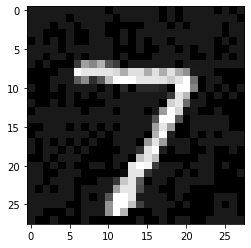

0.37


In [ ]:
imshow(fgsm(model, X, y, eps), 0)
print(accuracy(model, fgsm(model, X, y, eps), y))

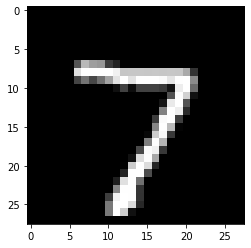

0.995


In [ ]:
imshow(fgsm(model, X, y, alpha), 0)
print(accuracy(model, fgsm(model, X, y, alpha), y))

### Testcase 2

Let's see the efficiency of gradient maker in producing a simple one-step universal attack

In [ ]:
def univ_1(model, X, y, eps=0.1):
    X_grad = dX(model, X, y).cpu().detach().numpy().reshape(X.shape[0], -1)
    print(X_grad.shape)
    onegrad = torch.from_numpy(gradient_maker(X_grad, epsilon=0., alpha=100)).view(X.shape[1:]).to(device)
    print(onegrad.shape)
    # X_advs = adv_clip(X + eps * torch.sign(onegrad), X, eps)
    # return X_advs
    pass
univ_1(model, X, y)

Streaming output truncated to the last 5000 lines.
Iter=21767, Condition=-6.040991158419655e-08
Iter=21768, Condition=-6.040357390513295e-08
Iter=21769, Condition=-6.039723701987267e-08
Iter=21770, Condition=-6.039090092829501e-08
Iter=21771, Condition=-6.03845656302811e-08
Iter=21772, Condition=-6.037823112570991e-08
Iter=21773, Condition=-6.037189741446175e-08
Iter=21774, Condition=-6.036556449641526e-08
Iter=21775, Condition=-6.035923237145083e-08
Iter=21776, Condition=-6.035290103944704e-08
Iter=21777, Condition=-6.034657050028443e-08
Iter=21778, Condition=-6.034024075384156e-08
Iter=21779, Condition=-6.033391179999953e-08
Iter=21780, Condition=-6.032758363863824e-08
Iter=21781, Condition=-6.032125626963559e-08
Iter=21782, Condition=-6.031492969287289e-08
Iter=21783, Condition=-6.030860390822947e-08
Iter=21784, Condition=-6.030227891558549e-08
Iter=21785, Condition=-6.029595471482152e-08
Iter=21786, Condition=-6.028963130581543e-08
Iter=21787, Condition=-6.0283308688449e-08
Iter=21

KeyboardInterrupt: ignored

In [ ]:
imshow(univ_1(model, X, y, eps), 0)
print(accuracy(model, univ_1(model, X, y, eps), y))

ValueError: ignored

In [ ]:
imshow(univ_1(model, X, y, alpha), 0)
print(accuracy(model, univ_1(model, X, y, alpha), y))